setting the output map dtype to [dtype('float64')]


<Figure size 1400x700 with 0 Axes>

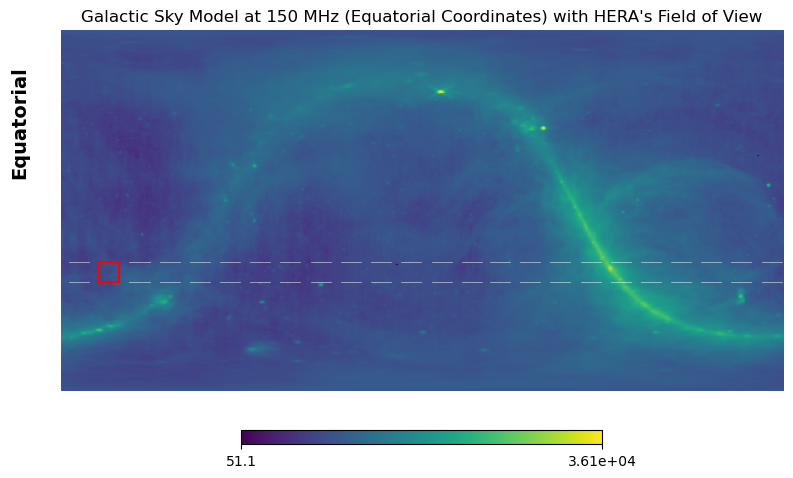

In [1]:
import pygdsm
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time
import astropy.units as u
from datetime import datetime, timedelta

# Define the frequency in MHz (e.g., 150 MHz)
frequency = 150

# Generate and save the GSM 2008 sky model at 150 MHz
gsm_2008 = pygdsm.GlobalSkyModel(freq_unit='MHz')
sky_map = gsm_2008.generate(frequency)

# Determine the number of pixels (nside parameter) for the HEALPix map
nside = 256  # Higher resolution

# Generate the HEALPix map
healpix_map = hp.ud_grade(sky_map, nside_out=nside)

# Save the HEALPix map to a FITS file
hp.write_map("healpix_map.fits", healpix_map, overwrite=True)

# Read the HEALPix map from the FITS file
healpix_map = hp.read_map("healpix_map.fits")

# Create a Rotator object to convert from Galactic to Equatorial coordinates
rotator = hp.Rotator(coord=['G', 'C'])

# Rotate the HEALPix map to Equatorial coordinates
equatorial_map = rotator.rotate_map_pixel(healpix_map)

# HERA location
hera_lon = 21.428305555555557
hera_lat = -30.72152777777791
hera_height = 1073.0
location = EarthLocation.from_geodetic(lat=hera_lat, lon=hera_lon, height=hera_height)

# Define the declination strip covered by HERA
hera_dec = -30.7
fov_radius_deg = 5  # Radius of the field of view in degrees

# Ask the user to input the date and time for highlighting
user_input = input("Enter the date and time (YYYY-MM-DD HH:MM:SS) or press Enter to use default: ")

# Set a default date and time if user input is invalid or empty
try:
    highlight_time = datetime.strptime(user_input, "%Y-%m-%d %H:%M:%S")
except ValueError:
    highlight_time = datetime(2024, 8, 5, 12, 0, 0)  # Default to August 5, 2024, at 12:00 PM

# Plot the equatorial sky model in Cartesian coordinates
plt.figure(figsize=(14, 7))
hp.cartview(equatorial_map, coord=['C'], title="Galactic Sky Model at 150 MHz (Equatorial Coordinates) with HERA's Field of View", norm='log', xsize=2000, return_projected_map=False)

# Loop over 24 hours to overlay the strip of the field of view
for hour in range(24):
    # Update observing time
    current_time = datetime(2024, 8, 5, 0, 0, 0) + timedelta(hours=hour)
    observer_time = Time(current_time)
    
    # Define the zenith in altaz coordinates
    zenith = SkyCoord(alt=90*u.deg, az=0*u.deg, frame=AltAz(obstime=observer_time, location=location))
    
    # Convert the zenith to equatorial coordinates
    zenith_radec = zenith.transform_to('icrs')
    ra = zenith_radec.ra.deg  # Right Ascension of the zenith
    
    # Calculate the RA range for the strip
    ra_range = np.linspace(ra - fov_radius_deg, ra + fov_radius_deg, 100)
    dec_range_upper = [hera_dec + fov_radius_deg] * 100
    dec_range_lower = [hera_dec - fov_radius_deg] * 100
    
    # Plot the upper and lower boundaries of the strip
    hp.visufunc.projplot(ra_range, dec_range_upper, lonlat=True, color='white', linewidth=0.5, alpha=0.7)
    hp.visufunc.projplot(ra_range, dec_range_lower, lonlat=True, color='white', linewidth=0.5, alpha=0.7)

# Highlight the specific area for the user-provided date and time
observer_time_highlight = Time(highlight_time)
zenith_highlight = SkyCoord(alt=90*u.deg, az=0*u.deg, frame=AltAz(obstime=observer_time_highlight, location=location))
zenith_radec_highlight = zenith_highlight.transform_to('icrs')
ra_highlight = zenith_radec_highlight.ra.deg

# Calculate the RA and Dec boundaries for the highlighted area
ra_range_highlight = np.linspace(ra_highlight - fov_radius_deg, ra_highlight + fov_radius_deg, 100)
dec_upper_highlight = [hera_dec + fov_radius_deg] * 100
dec_lower_highlight = [hera_dec - fov_radius_deg] * 100

# Plot the upper, lower, and side boundaries of the highlighted area
hp.visufunc.projplot(ra_range_highlight, dec_upper_highlight, lonlat=True, color='red', linewidth=1.5, alpha=1.0)
hp.visufunc.projplot(ra_range_highlight, dec_lower_highlight, lonlat=True, color='red', linewidth=1.5, alpha=1.0)
hp.visufunc.projplot([ra_highlight - fov_radius_deg, ra_highlight - fov_radius_deg], [hera_dec - fov_radius_deg, hera_dec + fov_radius_deg], lonlat=True, color='red', linewidth=1.5, alpha=1.0)
hp.visufunc.projplot([ra_highlight + fov_radius_deg, ra_highlight + fov_radius_deg], [hera_dec - fov_radius_deg, hera_dec + fov_radius_deg], lonlat=True, color='red', linewidth=1.5, alpha=1.0)

# Show the plot
plt.show()
